In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from GMBDT import GMBDT

### 1-1. 1D array Anomaly Detection Example

In [29]:
# mean=3, var=1, num of samples=100
array_normal_1d = np.random.normal(3, 1, 1000)

# range min=5, range max=10, num of samples=5
array_anomaly_1d = np.random.uniform(5, 10, 50)

# labeling: normal sample to 0, anomaly sample to 1
array_normal_1d = np.concatenate((array_normal_1d.reshape(-1, 1), np.zeros_like(array_normal_1d).reshape(-1, 1)), axis=1)
array_anomaly_1d = np.concatenate((array_anomaly_1d.reshape(-1, 1), np.ones_like(array_anomaly_1d).reshape(-1, 1)), axis=1)

array_ex_1d = np.concatenate((array_normal_1d, array_anomaly_1d), axis=0)
np.random.shuffle(array_ex_1d)

C:\Users\M\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='label', ylabel='value'>

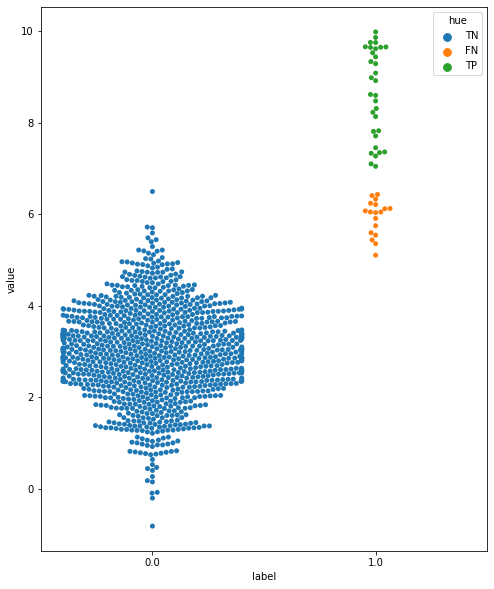

In [32]:
bgmm = GMBDT(min_sample=20, ratio_criteria=0.1)
pred = bgmm.fit_predict(array_ex_1d[:, 0], weight_type="linear", criteria=0.5)

array_result = np.concatenate((array_ex_1d, pred.reshape(-1, 1)), axis=1)
df_result = pd.DataFrame(array_result, columns = ["value", "label", "pred"])

df_result["hue"] = "TN"                                                             # Actual Normal, Pred Normal
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 0), "hue"] = "FN"   # Actual Anomaly, Pred Normal
df_result.loc[(df_result["label"] == 0) & (df_result["pred"] == 1), "hue"] = "FP"   # Actual Normal, Pred Anomaly
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 1), "hue"] = "TP"   # Actual Anomaly, Pred Anomaly

plt.figure(figsize=(8, 10))
sns.swarmplot(data=df_result, x="label", y="value", hue="hue")

### 1-2. 1D array Anomaly Detection Example (when dataset is clear and not include anomaly data)

In [26]:
# mean=3, var=1, num of samples=100
array_normal_1d_clear = np.random.normal(3, 1, 1000)
# mean=10, var=2, num of samples=100
array_normal_1d_clear2 = np.random.normal(10, 2, 700)
array_normal_1d_clear = np.concatenate((array_normal_1d_clear, array_normal_1d_clear2))

# range min=15, range max=20, num of samples=50
array_anomaly_1d_clear = np.random.uniform(15, 30, 50)

# labeling: normal sample to 0, anomaly sample to 1
array_normal_1d_clear = np.concatenate((array_normal_1d_clear.reshape(-1, 1), np.zeros_like(array_normal_1d_clear).reshape(-1, 1)), axis=1)
array_anomaly_1d_clear = np.concatenate((array_anomaly_1d_clear.reshape(-1, 1), np.ones_like(array_anomaly_1d_clear).reshape(-1, 1)), axis=1)

np.random.shuffle(array_normal_1d_clear)

C:\Users\M\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='label', ylabel='value'>

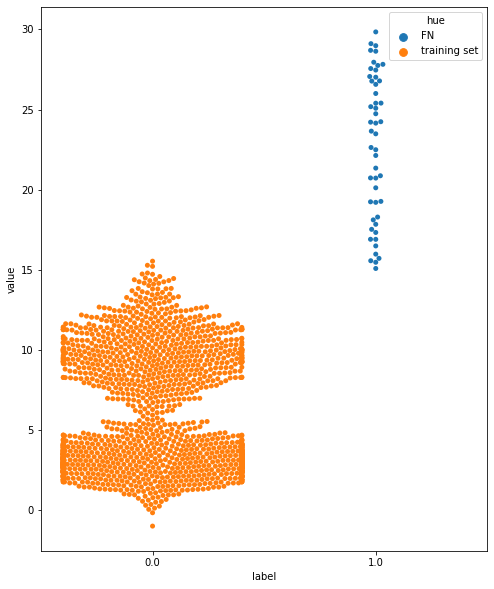

In [27]:
bgmm = GMBDT(min_sample=20, ratio_criteria=0.1)
bgmm.fit(array_normal_1d_clear[:, :-1])
pred = bgmm.predict(array_anomaly_1d_clear[:, :-1], weight_type="linear", criteria=0.5)

array_result = np.concatenate((array_anomaly_1d_clear, pred.reshape(-1, 1)), axis=1)
df_result = pd.DataFrame(array_result, columns = ["value", "label", "pred"])

df_result["hue"] = "TN"                                                             # Actual Normal, Pred Normal
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 0), "hue"] = "FN"   # Actual Anomaly, Pred Normal
df_result.loc[(df_result["label"] == 0) & (df_result["pred"] == 1), "hue"] = "FP"   # Actual Normal, Pred Anomaly
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 1), "hue"] = "TP"   # Actual Anomaly, Pred Anomaly

df_train_set = pd.DataFrame(array_normal_1d_clear, columns = ["value", "label"])
df_train_set["hue"] = "training set"
df_plot = pd.concat([df_result, df_train_set])


plt.figure(figsize=(8, 10))
sns.swarmplot(data=df_plot, x="label", y="value", hue="hue")

##### * hyperparameter "ratio_criteria" is for prevent the overfitting.
##### If ratio of smaller size cluster to bigger size cluster is greater than "ratio_criteria", we can stop clustering.
##### Ex) # of cluster1: 1000, # of cluster2: 501
##### if ratio_criteria = 0.5, ratio of sizes of clusters is 501/1000 = 0.501. So, clustering is stop.
##### when clusters have similar size, you should control this parameter.

C:\Users\M\AppData\Roaming\Python\Python38\site-packages\seaborn\categorical.py:1296: UserWarning: 34.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='label', ylabel='value'>

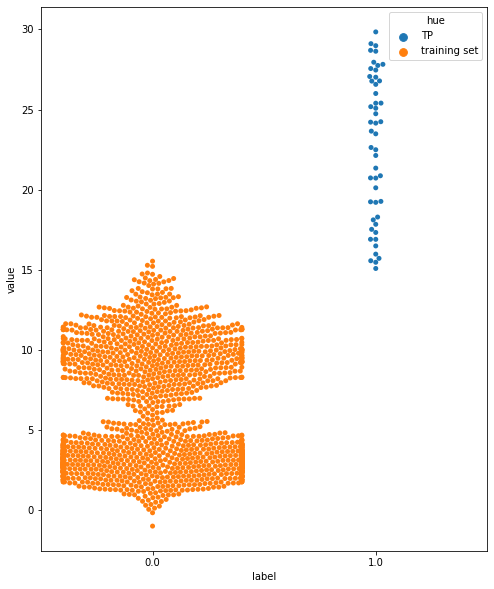

In [28]:
bgmm = GMBDT(min_sample=20, ratio_criteria=0.7)
bgmm.fit(array_normal_1d_clear[:, :-1])
pred = bgmm.predict(array_anomaly_1d_clear[:, :-1], weight_type="linear", criteria=0.5)

array_result = np.concatenate((array_anomaly_1d_clear, pred.reshape(-1, 1)), axis=1)
df_result = pd.DataFrame(array_result, columns = ["value", "label", "pred"])

df_result["hue"] = "TN"                                                             # Actual Normal, Pred Normal
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 0), "hue"] = "FN"   # Actual Anomaly, Pred Normal
df_result.loc[(df_result["label"] == 0) & (df_result["pred"] == 1), "hue"] = "FP"   # Actual Normal, Pred Anomaly
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 1), "hue"] = "TP"   # Actual Anomaly, Pred Anomaly

df_train_set = pd.DataFrame(array_normal_1d_clear, columns = ["value", "label"])
df_train_set["hue"] = "training set"
df_plot = pd.concat([df_result, df_train_set])


plt.figure(figsize=(8, 10))
sns.swarmplot(data=df_plot, x="label", y="value", hue="hue")

##### Result is different by "ratio_criteria" value.

### 2-1. 2D array Anomaly Detection Example

In [6]:
# mean=3, var=1, num of samples=2000
array_normal_2d = 3 + np.random.randn(2000, 2) * 1

# range min=5, range max=10, num of samples=100
array_anomaly_2d = np.random.uniform(5, 10, size=(100, 2))

# labeling: normal sample to 0, anomaly sample to 1
array_normal_2d = np.concatenate((array_normal_2d, np.zeros_like(array_normal_2d[:, 0]).reshape(-1, 1)), axis=1)
array_anomaly_2d = np.concatenate((array_anomaly_2d, np.ones_like(array_anomaly_2d[:, 0]).reshape(-1, 1)), axis=1)

array_ex_2d = np.concatenate((array_normal_2d, array_anomaly_2d), axis=0)
np.random.shuffle(array_ex_2d)

<AxesSubplot:xlabel='x', ylabel='y'>

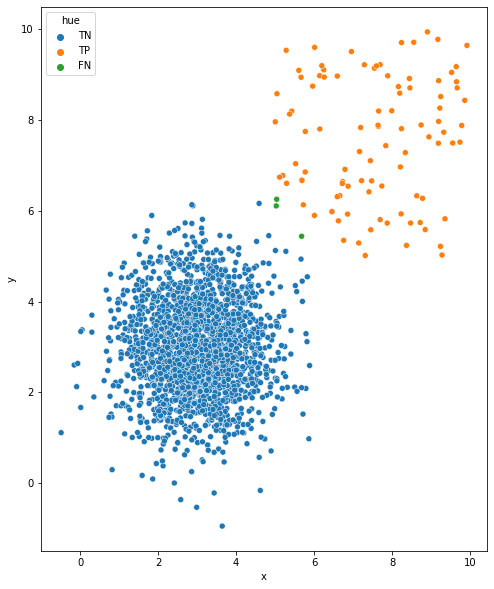

In [7]:
bgmm = GMBDT(min_sample=20, ratio_criteria=0.1)
pred = bgmm.fit_predict(array_ex_2d[:, :-1], weight_type="linear", criteria=0.5)

array_result = np.concatenate((array_ex_2d, pred.reshape(-1, 1)), axis=1)
df_result = pd.DataFrame(array_result, columns = ["x", "y", "label", "pred"])

df_result["hue"] = "TN"                                                             # Actual Normal, Pred Normal
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 0), "hue"] = "FN"   # Actual Anomaly, Pred Normal
df_result.loc[(df_result["label"] == 0) & (df_result["pred"] == 1), "hue"] = "FP"   # Actual Normal, Pred Anomaly
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 1), "hue"] = "TP"   # Actual Anomaly, Pred Anomaly

plt.figure(figsize=(8, 10))
sns.scatterplot(data=df_result, x="x", y="y", hue="hue")

### 2-2. 2D array Anomaly Detection Example (when dataset is clear and not include anomaly data)

In [13]:
# mean=3, var=1, num of samples=2000
array_normal_2d_clear = 3 + np.random.randn(2000, 2) * 1
# mean=10, var=2, num of samples=1000
array_normal_2d_clear2 = 10 + np.random.randn(1000, 2) * 2
array_normal_2d_clear = np.concatenate((array_normal_2d_clear, array_normal_2d_clear2))

# range min=12, range max=30, num of samples=200
array_anomaly_2d_clear = np.random.uniform(15, 30, size=(200, 2))

# labeling: normal sample to 0, anomaly sample to 1
array_normal_2d_clear = np.concatenate((array_normal_2d_clear, np.zeros_like(array_normal_2d_clear[:, 0]).reshape(-1, 1)), axis=1)
array_anomaly_2d_clear = np.concatenate((array_anomaly_2d_clear, np.ones_like(array_anomaly_2d_clear[:, 0]).reshape(-1, 1)), axis=1)


np.random.shuffle(array_normal_2d_clear)

<AxesSubplot:xlabel='x', ylabel='y'>

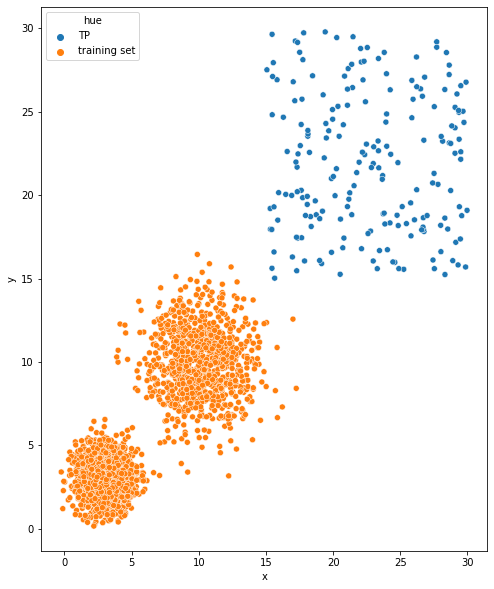

In [14]:
bgmm = GMBDT(min_sample=20, ratio_criteria=0.5)
bgmm.fit(array_normal_2d_clear[:, :-1])
pred = bgmm.predict(array_anomaly_2d_clear[:, :-1], weight_type="linear", criteria=0.5)

array_result = np.concatenate((array_anomaly_2d_clear, pred.reshape(-1, 1)), axis=1)

df_result = pd.DataFrame(array_result, columns = ["x", "y", "label", "pred"])
df_result["hue"] = "TN"                                                             # Actual Normal, Pred Normal
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 0), "hue"] = "FN"   # Actual Anomaly, Pred Normal
df_result.loc[(df_result["label"] == 0) & (df_result["pred"] == 1), "hue"] = "FP"   # Actual Normal, Pred Anomaly
df_result.loc[(df_result["label"] == 1) & (df_result["pred"] == 1), "hue"] = "TP"   # Actual Anomaly, Pred Anomaly

df_train_set = pd.DataFrame(array_normal_2d_clear, columns = ["x", "y", "label"])
df_train_set["hue"] = "training set"
df_plot = pd.concat([df_result, df_train_set])


plt.figure(figsize=(8, 10))
sns.scatterplot(data=df_plot, x="x", y="y", hue="hue")